<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/CapsNet-LSTM/blob/main/CapsNet_LSTM_C6H6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal Prediction for Financial Time Series Using A Deep Ensemble with Hybrid CapsNet-LSTM Neural Networks: Using real world data (C6H6)


In [1]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [2]:
import random

In [3]:
# # Set seed
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1)

In [4]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
print(tf.__version__)

2.11.0


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [7]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [8]:
C6H6_raw = pd.read_excel('/content/gdrive/MyDrive/C6H6/C6H6.xlsx')
C6H6_raw

,Date,Time,C6H6(GT)
0,2004-09-08,18:00:00,18.912738
1,2004-09-08,19:00:00,24.085687
2,2004-09-08,20:00:00,18.054085
3,2004-09-08,21:00:00,15.807518
4,2004-09-08,22:00:00,14.649682
...,...,...,...
2321,2004-12-14,12:00:00,21.664148
2322,2004-12-14,13:00:00,25.820425
2323,2004-12-14,14:00:00,21.812865
2324,2004-12-14,15:00:00,20.617130


In [9]:
series = C6H6_raw.iloc[:,2] # close price

In [10]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

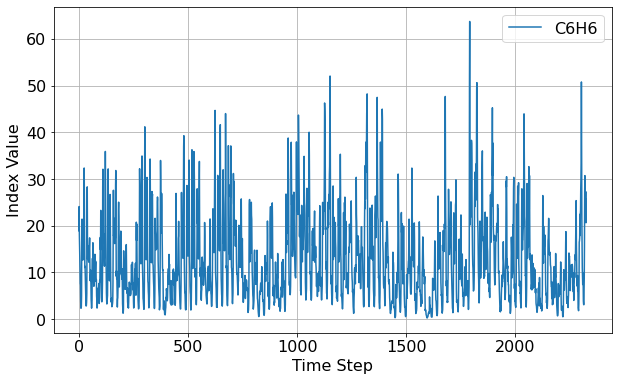

In [12]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int(len(series)*0.25)          # data splitting, the last G.SPLIT_TIME samples are test set.
    WINDOW_SIZE = 50                                # sequence length
    BATCH_SIZE = 32                                  # batch size

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["C6H6"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/C6H6_original.svg")
plt.show()

## Processing the data

The `train_test_split` and `windowed_dataset` functions:

In [13]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test

# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)

In [14]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [15]:
series_norm = min_max_normalization(G.SERIES)

In [16]:
series_train_norm = series_norm[:-G.SPLIT_TIME]

series_test_norm = series_norm[-G.SPLIT_TIME:]

In [17]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    #ds = ds.batch(batch_size).prefetch(1)
    return ds
#train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
#cal_set = windowed_dataset(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
train_set = windowed_dataset(series_norm[0:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
def bootstrap_dataset(train_set):
  
  biglist = list(train_set)
  bootstrap_list1 =[]
  bootstrap_list2 =[]
  features = []
  labels = []

  for i in range(len(biglist)):
    
    bootstrap_list1.append(random.choice(biglist))

  
    bootstrap_list2.append(list(bootstrap_list1[i]))

 
    features.append(bootstrap_list2[i][0])  

    labels.append(bootstrap_list2[i][1])

  features_tensor = tf.convert_to_tensor(features)
  labels_tensor = tf.convert_to_tensor(labels)

  features_constant = tf.constant(features_tensor)
  labels_constant = tf.constant(labels_tensor)

  bootstrap_dataset = tf.data.Dataset.from_tensor_slices((features_constant, labels_constant))
  bootstrap_dataset = bootstrap_dataset.batch(G.BATCH_SIZE).prefetch(1)

  return bootstrap_dataset

In [19]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [20]:
# Define PICP (PI coverage probability)

def PICP(upper_bound, lower_bound, real_value):
  c = np.array(0)
  for i in range(len(real_value)):
    if ((real_value[i] <= upper_bound[i]) & (real_value[i] >= lower_bound[i])):
      c = c+1
  picp = c / len(real_value)
  return picp


In [21]:
# Define NMPIW (Normalized Mean PI width)

def NMPIW(upper_bound, lower_bound, real_value):
   return tf.reduce_mean(upper_bound - lower_bound) / (np.max(real_value)-np.min(real_value))

In [22]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [23]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [24]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [25]:
input_shape = (G.WINDOW_SIZE, 1)

In [26]:
# Define the number of bootstraps
num_bootstraps = 20
# Define alpha
alpha = 0.05

In [27]:
K.clear_session()

In [28]:
series_y = np.array(series[G.WINDOW_SIZE:])

# save time series
np.savetxt("/content/gdrive/MyDrive/C6H6/files/test_set_values_C6H6.csv", 
           series_test.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/files/whole_values_C6H6.csv", 
           series_y.T, delimiter=",")

## Compiling the model


### Defining the model architecture (CapsNet-LSTM)


In [29]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [30]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

#@tf.keras.utils.register_keras_serializable() should use this line next time when need to save the model with a custom layer.
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

### Determine the number of Epoch

In [31]:
# Build the model with the default setting. LSTM units = 200, Convolution filters = 256, kernel size = 2, stride = 1, learning rate = 0.0005
def CapsNet_LSTM():
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
  
    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 32, 8))(conv1d_1)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 256, routings = 3))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(200)(digit_caps)

    # Dense layer

    output = tf.keras.layers.Dense(1)(lstm)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [32]:
capsnet_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      capsnet_lstm = CapsNet_LSTM()
    # Fit with the entire dataset.
    capsnet_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    capsnet_lstm_ensemble.append(capsnet_lstm)

Instructions for updating:
Use fn_output_signature instead
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignor

In [33]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 reshape_19 (Reshape)        (None, 50, 32, 8)         0         
                                                                 
 lambda_19 (Lambda)          (None, 50, 32, 8)         0         
                                                                 
 time_distributed_19 (TimeDi  (None, 50, 256)          65536     
 stributed)                                                      
                                                                 
 lstm_19 (LSTM)              (None, 200)               365600    
                                                      

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [34]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

capsnet_lstm_ensemble_pred = tf.reduce_mean([model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze() for capsnet_lstm in capsnet_lstm_ensemble], axis=0)

series_hat_capsnet_lstm = reverse_normalization(capsnet_lstm_ensemble_pred)

72/72 [==============================] - 6s 30ms/step


In [35]:
series_y_hat_capsnet_lstm = np.array(list(series_hat_capsnet_lstm[:-1]))

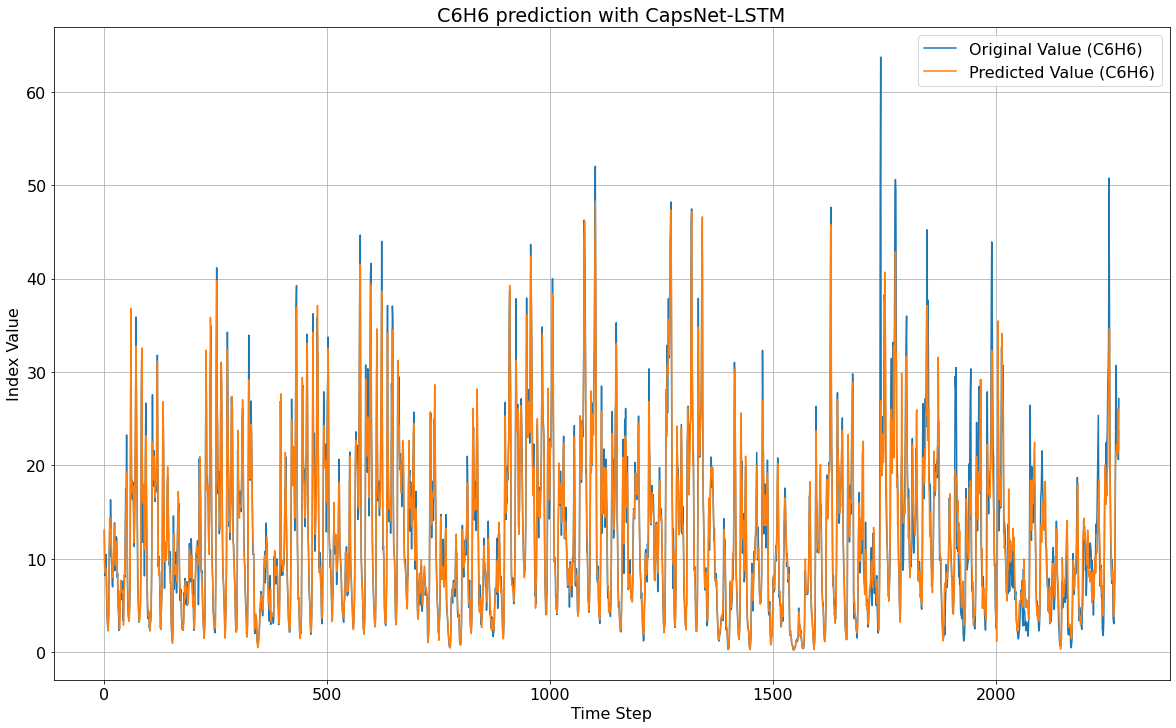

In [36]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/capsnet_lstm_forecasts_whole_C6H6.svg")

In [37]:
# error series

abs_error_capsnet_lstm = np.abs(series_y-series_y_hat_capsnet_lstm)
series_test_hat_capsnet_lstm = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:]
series_test_hat_capsnet_lstm_up = []
series_test_hat_capsnet_lstm_low = []

In [38]:
for i in range(len(series_test)):
  error = np.sort(abs_error_capsnet_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_capsnet_lstm_up.append(series_test_hat_capsnet_lstm[i] + up_bound)
  series_test_hat_capsnet_lstm_low.append(series_test_hat_capsnet_lstm[i] + low_bound)

In [39]:
series_test_hat_capsnet_lstm_up = np.array(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.array(series_test_hat_capsnet_lstm_low)

In [40]:
series_test_hat_capsnet_lstm_up = np.squeeze(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.squeeze(series_test_hat_capsnet_lstm_low)

In [41]:
bound_width_capsnet_lstm = series_test_hat_capsnet_lstm_up-series_test_hat_capsnet_lstm_low

In [42]:
PICP_capsnet_lstm = PICP(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [43]:
PICP_capsnet_lstm

0.8123924268502581

In [44]:
NMPIW_capsnet_lstm = NMPIW(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [45]:
NMPIW_capsnet_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.14828059381289466>

In [46]:
rmse_capsnet_lstm, mae_capsnet_lstm, mape_capsnet_lstm= compute_metrics(series_test, series_test_hat_capsnet_lstm)

print(f"rmse: {rmse_capsnet_lstm:.2f}, mae: {mae_capsnet_lstm:.2f} , mape: {mape_capsnet_lstm:.2f} for forecast")

rmse: 4.51, mae: 2.92 , mape: 31.07 for forecast


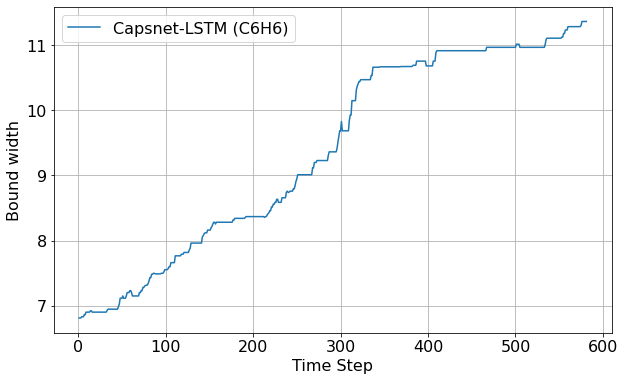

In [47]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Capsnet-LSTM (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/capsnet_lstm_forecasts_bound_width_C6H6.svg")

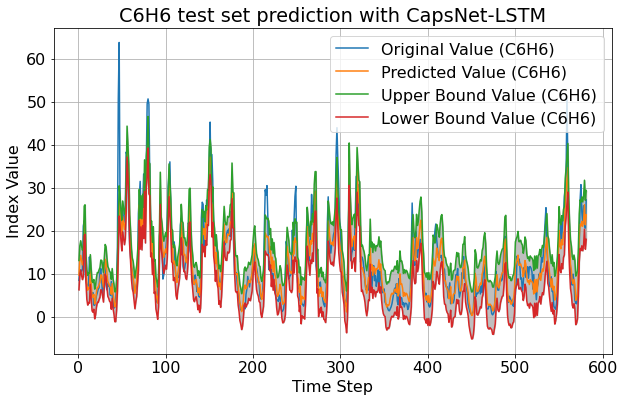

In [48]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/capsnet_lstm_forecasts_bounds_C6H6.svg")

In [49]:
# Save_weights model

capsnet_lstm_ensemble[0].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_0.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[1].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_1.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[2].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_2.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[3].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_3.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[4].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_4.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[5].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_5.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[6].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_6.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[7].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_7.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[8].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_8.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[9].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_9.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[10].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_10.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[11].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_11.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[12].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_12.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[13].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_13.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[14].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_14.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[15].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_15.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[16].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_16.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[17].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_17.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[18].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_18.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[19].save_weights("/content/gdrive/MyDrive/C6H6/capsnet_lstm_ensemble/capsnet_lstm_C6H6_19.h5", overwrite=True, save_format=None, options=None)

In [50]:

capsnet_lstm.save_weights('/content/gdrive/MyDrive/C6H6/capsnet_lstm_C6H6_weights.h5', overwrite=True, save_format=None, options=None)

In [51]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/C6H6/capsnet_lstm_predicted_mean_C6H6.csv", 
           series_test_hat_capsnet_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/capsnet_lstm_predicted_up_C6H6.csv", 
           series_test_hat_capsnet_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/capsnet_lstm_predicted_low_C6H6.csv", 
           series_test_hat_capsnet_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/capsnet_lstm_predicted_whole_C6H6.csv", 
           series_y_hat_capsnet_lstm.T, delimiter=",")

## Baseline (LSTM, CNN-LSTM)

### LSTM

In [52]:
# Build the model with the best hp.
def LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [53]:
lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      lstm = LSTM()
    # Fit with the entire dataset.
    lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    lstm_ensemble.append(lstm)

Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceb

In [54]:
print(lstm.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 200)               161600    
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

lstm_ensemble_pred = tf.reduce_mean([model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze() for lstm in lstm_ensemble], axis=0)

series_hat_lstm = reverse_normalization(lstm_ensemble_pred)

72/72 [==============================] - 4s 17ms/step


In [56]:

series_y_hat_lstm = np.array(list(series_hat_lstm[:-1]))

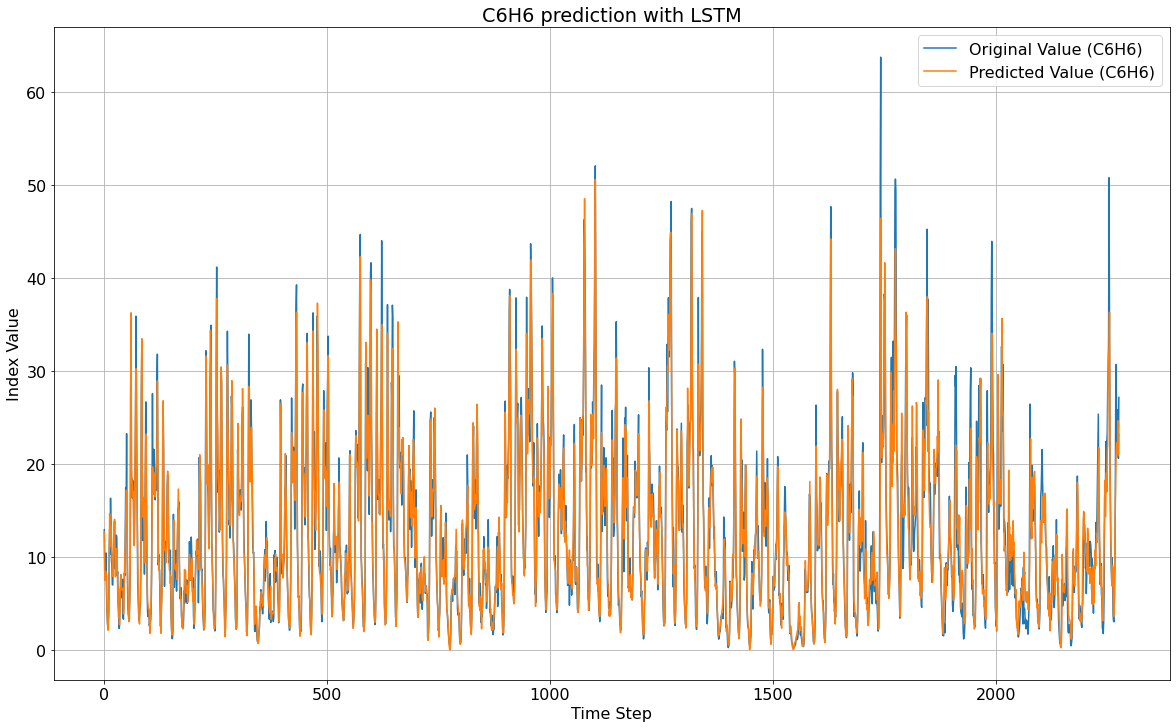

In [57]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/lstm_forecasts_whole_C6H6.svg")

In [58]:
# error series

abs_error_lstm = np.abs(series_y-series_y_hat_lstm)
series_test_hat_lstm = series_y_hat_lstm[-G.SPLIT_TIME:]
series_test_hat_lstm_up = []
series_test_hat_lstm_low = []

In [59]:
for i in range(len(series_test)):
  error = np.sort(abs_error_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_lstm_up.append(series_test_hat_lstm[i] + up_bound)
  series_test_hat_lstm_low.append(series_test_hat_lstm[i] + low_bound)

In [60]:
series_test_hat_lstm_up = np.array(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.array(series_test_hat_lstm_low)

In [61]:
series_test_hat_lstm_up = np.squeeze(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.squeeze(series_test_hat_lstm_low)

In [62]:
bound_width_lstm = series_test_hat_lstm_up-series_test_hat_lstm_low

In [63]:
PICP_lstm = PICP(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [64]:
PICP_lstm

0.8605851979345955

In [65]:
NMPIW_lstm = NMPIW(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [66]:
NMPIW_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.16662628581398872>

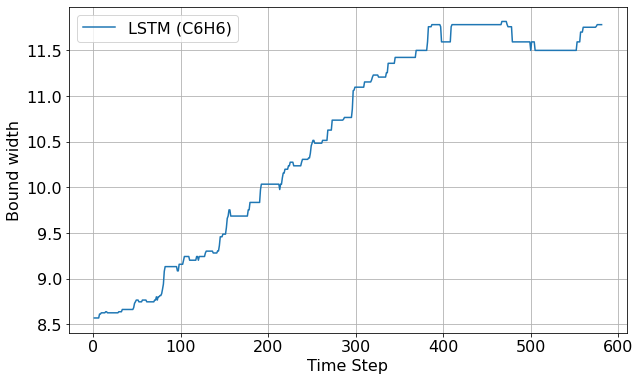

In [67]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["LSTM (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/lstm_forecasts_bound_width_C6H6.svg")

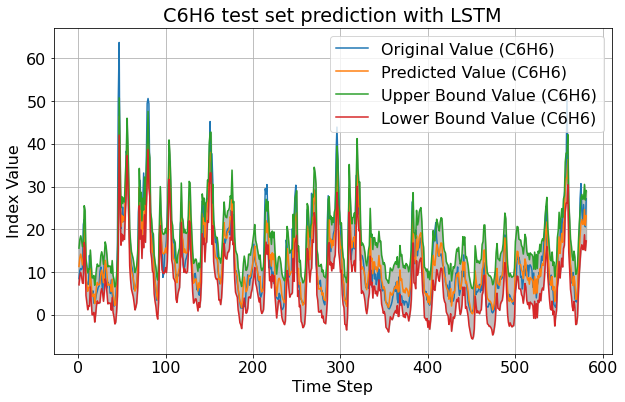

In [68]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/lstm_forecasts_bounds_C6H6.svg")

In [69]:
rmse_lstm, mae_lstm, mape_lstm= compute_metrics(series_test, series_test_hat_lstm)

print(f"rmse: {rmse_lstm:.2f}, mae: {mae_lstm:.2f} , mape: {mape_lstm:.2f} for forecast")

rmse: 4.11, mae: 2.75 , mape: 31.10 for forecast


In [70]:
# Save model

lstm_ensemble[0].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_0.h5")
lstm_ensemble[1].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_1.h5")
lstm_ensemble[2].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_2.h5")
lstm_ensemble[3].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_3.h5")
lstm_ensemble[4].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_4.h5")
lstm_ensemble[5].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_5.h5")
lstm_ensemble[6].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_6.h5")
lstm_ensemble[7].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_7.h5")
lstm_ensemble[8].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_8.h5")
lstm_ensemble[9].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_9.h5")
lstm_ensemble[10].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_10.h5")
lstm_ensemble[11].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_11.h5")
lstm_ensemble[12].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_12.h5")
lstm_ensemble[13].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_13.h5")
lstm_ensemble[14].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_14.h5")
lstm_ensemble[15].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_15.h5")
lstm_ensemble[16].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_16.h5")
lstm_ensemble[17].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_17.h5")
lstm_ensemble[18].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_18.h5")
lstm_ensemble[19].save("/content/gdrive/MyDrive/C6H6/lstm_ensemble/lstm_C6H6_19.h5")


In [71]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/C6H6/lstm_predicted_mean_C6H6.csv", 
           series_test_hat_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/lstm_predicted_up_C6H6.csv", 
           series_test_hat_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/lstm_predicted_low_C6H6.csv", 
           series_test_hat_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/lstm_predicted_whole_C6H6.csv", 
           series_y_hat_lstm.T, delimiter=",")

### GRU

In [72]:
def GRU():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.GRU(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [73]:
gru_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      gru = GRU()
    # Fit with the entire dataset.
    gru.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    gru_ensemble.append(gru)

Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceb

In [74]:
print(lstm.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 200)               161600    
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

gru_ensemble_pred = tf.reduce_mean([model_forecast(gru, series_norm, G.WINDOW_SIZE).squeeze() for gru in gru_ensemble], axis=0)

series_hat_gru = reverse_normalization(gru_ensemble_pred)

72/72 [==============================] - 4s 18ms/step


In [76]:
series_y_hat_gru = np.array(list(series_hat_gru[:-1]))

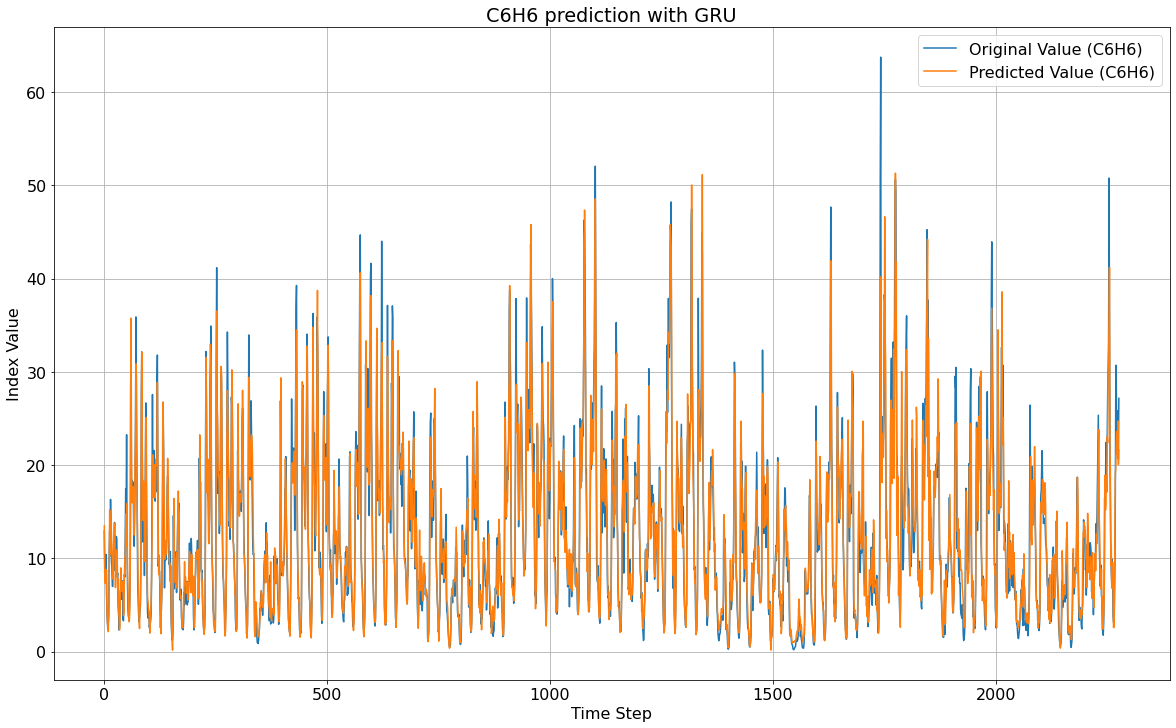

In [77]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_gru)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with GRU")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/gru_forecasts_whole_C6H6.svg")

In [78]:
# error series

abs_error_gru = np.abs(series_y-series_y_hat_gru)
series_test_hat_gru = series_y_hat_gru[-G.SPLIT_TIME:]
series_test_hat_gru_up = []
series_test_hat_gru_low = []

In [79]:
for i in range(len(series_test)):
  error = np.sort(abs_error_gru[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_gru_up.append(series_test_hat_gru[i] + up_bound)
  series_test_hat_gru_low.append(series_test_hat_gru[i] + low_bound)

In [80]:
series_test_hat_gru_up = np.array(series_test_hat_gru_up)
series_test_hat_gru_low = np.array(series_test_hat_gru_low)
series_test_hat_gru_up = np.squeeze(series_test_hat_gru_up)
series_test_hat_gru_low = np.squeeze(series_test_hat_gru_low)
bound_width_gru = series_test_hat_gru_up-series_test_hat_gru_low
PICP_gru = PICP(series_test_hat_gru_up, series_test_hat_gru_low, series_test)
NMPIW_gru = NMPIW(series_test_hat_gru_up, series_test_hat_gru_low, series_test)


In [81]:
PICP_gru

0.9018932874354562

In [82]:
NMPIW_gru

<tf.Tensor: shape=(), dtype=float64, numpy=0.20562403013729805>

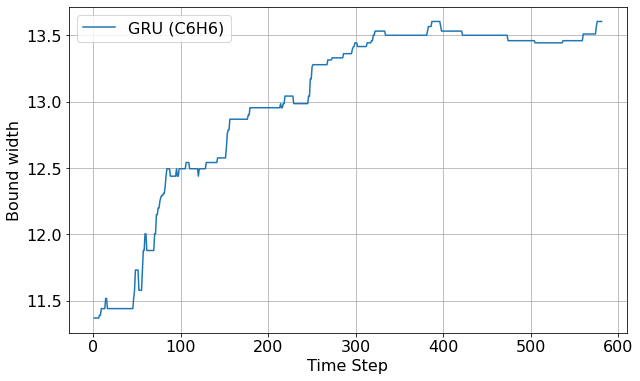

In [83]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_gru)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["GRU (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/gru_forecasts_bound_width_C6H6.svg")

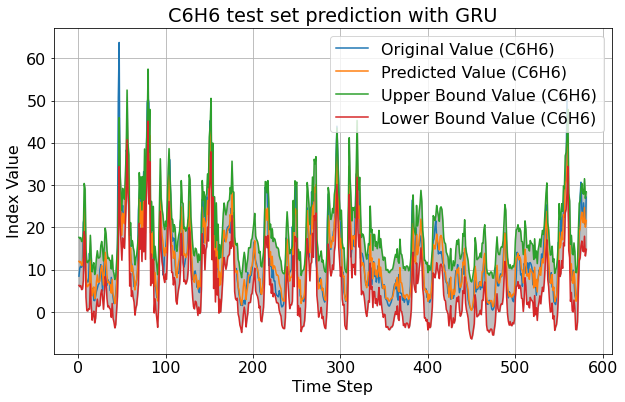

In [84]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_gru)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_gru_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_gru_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_gru_up, series_test_hat_gru_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with GRU")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/gru_forecasts_bounds_C6H6.svg")

In [85]:
rmse_gru, mae_gru, mape_gru= compute_metrics(series_test, series_test_hat_gru)

print(f"rmse: {rmse_gru:.2f}, mae: {mae_gru:.2f} , mape: {mape_gru:.2f} for forecast")

rmse: 4.28, mae: 2.79 , mape: 29.01 for forecast


In [86]:
# Save model

gru_ensemble[0].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_0.h5")
gru_ensemble[1].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_1.h5")
gru_ensemble[2].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_2.h5")
gru_ensemble[3].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_3.h5")
gru_ensemble[4].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_4.h5")
gru_ensemble[5].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_5.h5")
gru_ensemble[6].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_6.h5")
gru_ensemble[7].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_7.h5")
gru_ensemble[8].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_8.h5")
gru_ensemble[9].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_9.h5")
gru_ensemble[10].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_10.h5")
gru_ensemble[11].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_11.h5")
gru_ensemble[12].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_12.h5")
gru_ensemble[13].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_13.h5")
gru_ensemble[14].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_14.h5")
gru_ensemble[15].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_15.h5")
gru_ensemble[16].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_16.h5")
gru_ensemble[17].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_17.h5")
gru_ensemble[18].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_18.h5")
gru_ensemble[19].save("/content/gdrive/MyDrive/C6H6/gru_ensemble/gru_C6H6_19.h5")

In [87]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/C6H6/gru_predicted_mean_C6H6.csv", 
           series_test_hat_gru.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/gru_predicted_up_C6H6.csv", 
           series_test_hat_gru_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/gru_predicted_low_C6H6.csv", 
           series_test_hat_gru_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/gru_predicted_whole_C6H6.csv", 
           series_y_hat_gru.T, delimiter=",")

### RNN

In [88]:
def RNN():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.SimpleRNN(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [89]:
rnn_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      rnn = RNN()
    # Fit with the entire dataset.
    rnn.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    rnn_ensemble.append(rnn)

Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceb

In [90]:
print(rnn.summary())

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_19 (SimpleRNN)   (None, 200)               40400     
                                                                 
 dense_79 (Dense)            (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

rnn_ensemble_pred = tf.reduce_mean([model_forecast(rnn, series_norm, G.WINDOW_SIZE).squeeze() for rnn in rnn_ensemble], axis=0)

series_hat_rnn = reverse_normalization(rnn_ensemble_pred)

72/72 [==============================] - 3s 18ms/step


In [92]:
series_y_hat_rnn = np.array(list(series_hat_rnn[:-1]))

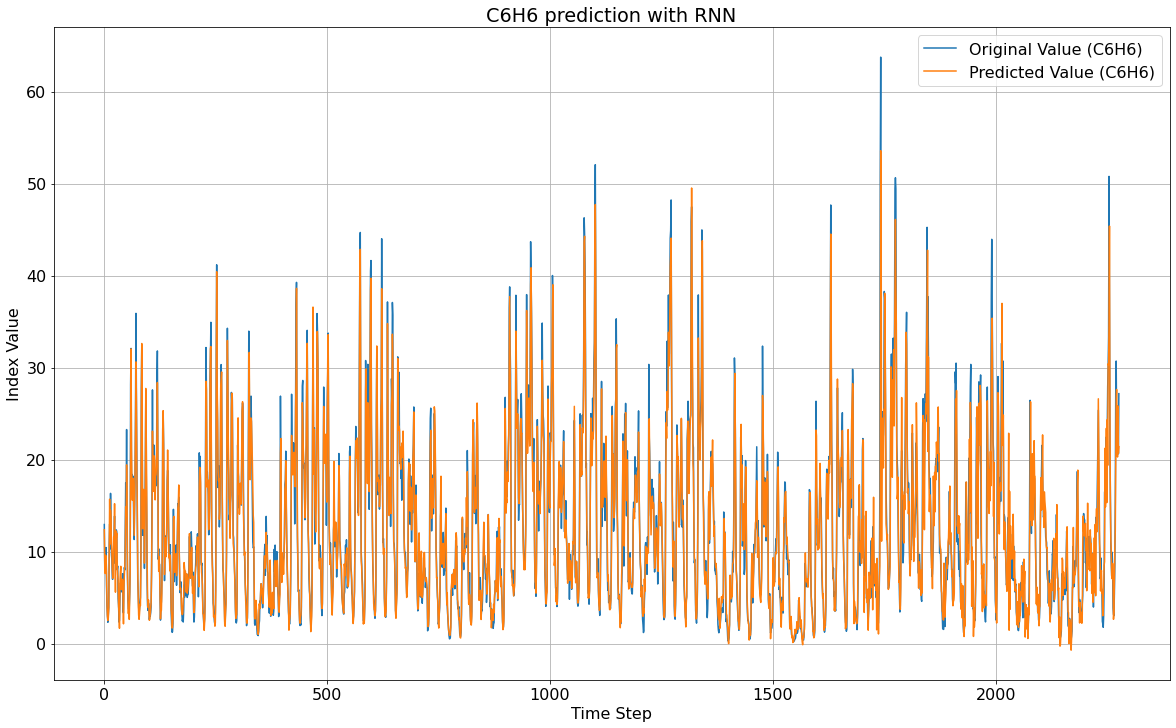

In [93]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_rnn)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with RNN")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/rnn_forecasts_whole_C6H6.svg")

In [94]:
# error series

abs_error_rnn = np.abs(series_y-series_y_hat_rnn)
series_test_hat_rnn = series_y_hat_rnn[-G.SPLIT_TIME:]
series_test_hat_rnn_up = []
series_test_hat_rnn_low = []

In [95]:
for i in range(len(series_test)):
  error = np.sort(abs_error_rnn[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_rnn_up.append(series_test_hat_rnn[i] + up_bound)
  series_test_hat_rnn_low.append(series_test_hat_rnn[i] + low_bound)

In [96]:
series_test_hat_rnn_up = np.array(series_test_hat_rnn_up)
series_test_hat_rnn_low = np.array(series_test_hat_rnn_low)
series_test_hat_rnn_up = np.squeeze(series_test_hat_rnn_up)
series_test_hat_rnn_low = np.squeeze(series_test_hat_rnn_low)
bound_width_rnn = series_test_hat_rnn_up-series_test_hat_rnn_low
PICP_rnn = PICP(series_test_hat_rnn_up, series_test_hat_rnn_low, series_test)
NMPIW_rnn = NMPIW(series_test_hat_rnn_up, series_test_hat_rnn_low, series_test)

In [97]:
PICP_rnn

0.8227194492254734

In [98]:
NMPIW_rnn

<tf.Tensor: shape=(), dtype=float64, numpy=0.14598769883142804>

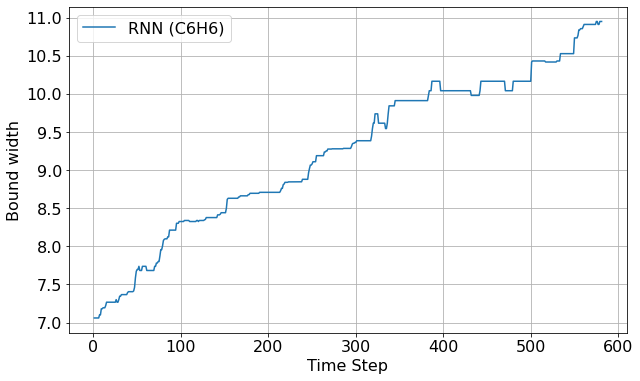

In [99]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_rnn)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["RNN (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/rnn_forecasts_bound_width_C6H6.svg")

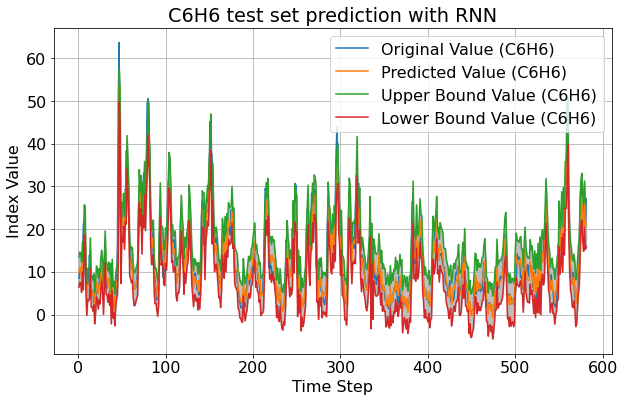

In [100]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn_up, series_test_hat_rnn_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with RNN")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/rnn_forecasts_bounds_C6H6.svg")

In [101]:
rmse_rnn, mae_rnn, mape_rnn= compute_metrics(series_test, series_test_hat_rnn)

print(f"rmse: {rmse_rnn:.2f}, mae: {mae_rnn:.2f} , mape: {mape_rnn:.2f} for forecast")

rmse: 4.17, mae: 2.78 , mape: 29.82 for forecast


In [102]:
# Save model

rnn_ensemble[0].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_0.h5")
rnn_ensemble[1].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_1.h5")
rnn_ensemble[2].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_2.h5")
rnn_ensemble[3].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_3.h5")
rnn_ensemble[4].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_4.h5")
rnn_ensemble[5].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_5.h5")
rnn_ensemble[6].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_6.h5")
rnn_ensemble[7].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_7.h5")
rnn_ensemble[8].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_8.h5")
rnn_ensemble[9].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_9.h5")
rnn_ensemble[10].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_10.h5")
rnn_ensemble[11].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_11.h5")
rnn_ensemble[12].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_12.h5")
rnn_ensemble[13].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_13.h5")
rnn_ensemble[14].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_14.h5")
rnn_ensemble[15].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_15.h5")
rnn_ensemble[16].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_16.h5")
rnn_ensemble[17].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_17.h5")
rnn_ensemble[18].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_18.h5")
rnn_ensemble[19].save("/content/gdrive/MyDrive/C6H6/rnn_ensemble/rnn_C6H6_19.h5")

In [103]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/C6H6/rnn_predicted_mean_C6H6.csv", 
           series_test_hat_rnn.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/rnn_predicted_up_C6H6.csv", 
           series_test_hat_rnn_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/rnn_predicted_low_C6H6.csv", 
           series_test_hat_rnn_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/rnn_predicted_whole_C6H6.csv", 
           series_y_hat_rnn.T, delimiter=",")

### Naive forecast

In [104]:
series_y_hat_naive = np.array(series[G.WINDOW_SIZE-1:-1])

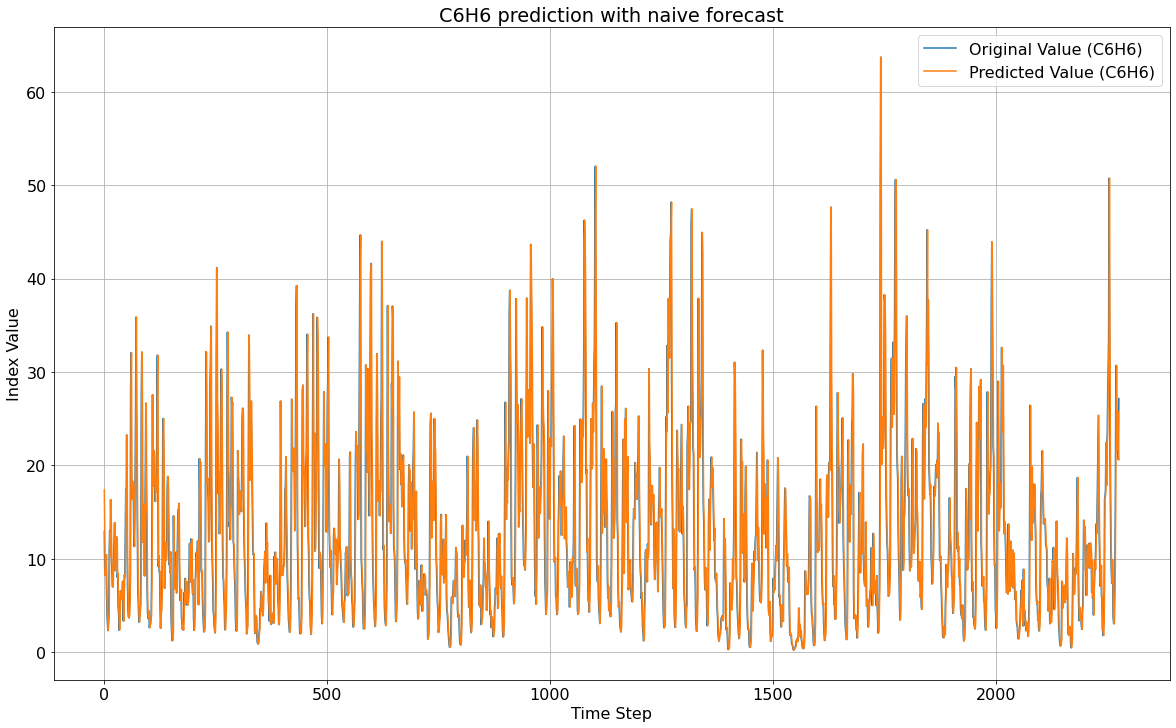

In [105]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_naive)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with naive forecast")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/naive_forecasts_whole_C6H6.svg")

In [106]:
abs_error_naive = np.abs(series_y-series_y_hat_naive)
series_test_hat_naive = series_y_hat_naive[-G.SPLIT_TIME:]
series_test_hat_naive_up = []
series_test_hat_naive_low = []

In [107]:
for i in range(len(series_test)):
  error = np.sort(abs_error_naive[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_naive_up.append(series_test_hat_naive[i] + up_bound)
  series_test_hat_naive_low.append(series_test_hat_naive[i] + low_bound)

In [108]:
series_test_hat_naive_up = np.array(series_test_hat_naive_up)
series_test_hat_naive_low = np.array(series_test_hat_naive_low)
series_test_hat_naive_up = np.squeeze(series_test_hat_naive_up)
series_test_hat_naive_low = np.squeeze(series_test_hat_naive_low)
bound_width_naive = series_test_hat_naive_up-series_test_hat_naive_low
PICP_naive = PICP(series_test_hat_naive_up, series_test_hat_naive_low, series_test)
NMPIW_naive = NMPIW(series_test_hat_naive_up, series_test_hat_naive_low, series_test)

In [109]:
PICP_naive

0.9604130808950087

In [110]:
NMPIW_naive

<tf.Tensor: shape=(), dtype=float64, numpy=0.3536539365623268>

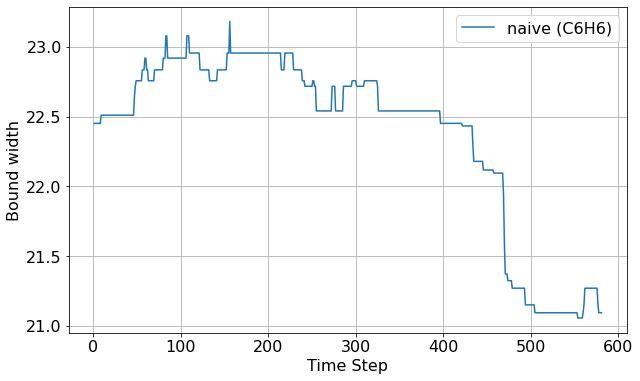

In [111]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_naive)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["naive (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/naive_forecasts_bound_width_C6H6.svg")

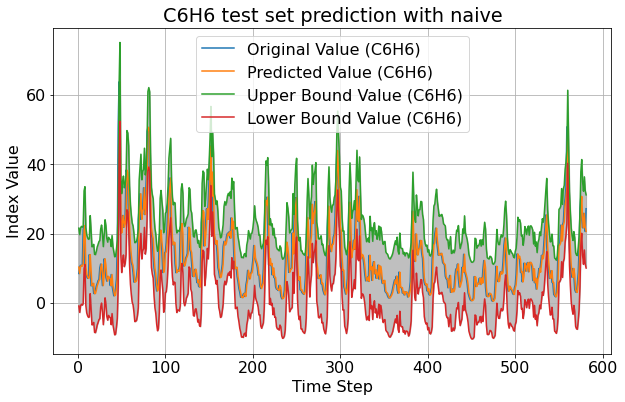

In [112]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_up, series_test_hat_naive_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with naive")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/naive_forecasts_bounds_C6H6.svg")

In [113]:
rmse_naive, mae_naive, mape_naive= compute_metrics(series_test, series_test_hat_naive)

print(f"rmse: {rmse_naive:.2f}, mae: {mae_naive:.2f} , mape: {mape_naive:.2f} for forecast")

rmse: 4.89, mae: 3.11 , mape: 28.17 for forecast


In [114]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/C6H6/naive_predicted_mean_C6H6.csv", 
           series_test_hat_naive.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/naive_predicted_up_C6H6.csv", 
           series_test_hat_naive_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/naive_predicted_low_C6H6.csv", 
           series_test_hat_naive_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/C6H6/naive_predicted_whole_C6H6.csv", 
           series_y_hat_naive.T, delimiter=",")

### CNN-LSTM

In [115]:
def CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=256, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

Epoch number is 500.

In [116]:
cnn_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      cnn_lstm = CNN_LSTM()
    # Fit with the entire dataset.
    cnn_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    cnn_lstm_ensemble.append(cnn_lstm)

Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7fe0e09c7310>
Traceb

In [117]:
print(cnn_lstm.summary())

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 50, 256)           768       
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 50, 256)          0         
 g1D)                                                            
                                                                 
 lstm_59 (LSTM)              (None, 200)               365600    
                                                                 
 dense_99 (Dense)            (None, 1)                 201       
                                                                 
Total params: 366,569
Trainable params: 366,569
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

cnn_lstm_ensemble_pred = tf.reduce_mean([model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze() for cnn_lstm in cnn_lstm_ensemble], axis=0)

series_hat_cnn_lstm = reverse_normalization(cnn_lstm_ensemble_pred)

72/72 [==============================] - 4s 19ms/step


In [119]:
series_y_hat_cnn_lstm = np.array(list(series_hat_cnn_lstm[:-1]))

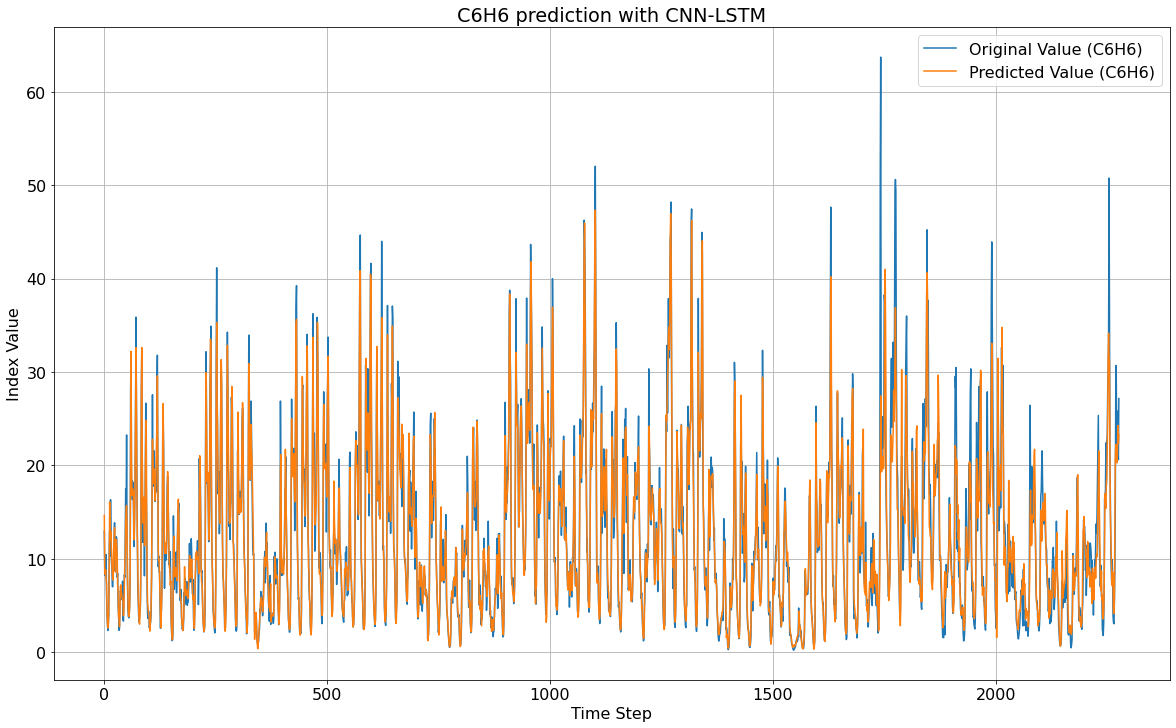

In [120]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/cnn_lstm_forecasts_whole_C6H6.svg")

In [121]:
# error series

abs_error_cnn_lstm = np.abs(series_y-series_y_hat_cnn_lstm)
series_test_hat_cnn_lstm = series_y_hat_cnn_lstm[-G.SPLIT_TIME:]
series_test_hat_cnn_lstm_up = []
series_test_hat_cnn_lstm_low = []

In [122]:
for i in range(len(series_test)):
  error = np.sort(abs_error_cnn_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_cnn_lstm_up.append(series_test_hat_cnn_lstm[i] + up_bound)
  series_test_hat_cnn_lstm_low.append(series_test_hat_cnn_lstm[i] + low_bound)

In [123]:
series_test_hat_cnn_lstm_up = np.array(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.array(series_test_hat_cnn_lstm_low)

In [124]:
series_test_hat_cnn_lstm_up = np.squeeze(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.squeeze(series_test_hat_cnn_lstm_low)

In [125]:
bound_width_cnn_lstm = series_test_hat_cnn_lstm_up-series_test_hat_cnn_lstm_low

In [126]:
PICP_cnn_lstm = PICP(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [127]:
PICP_cnn_lstm

0.8313253012048193

In [128]:
NMPIW_cnn_lstm = NMPIW(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [129]:
NMPIW_cnn_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.16030788519764985>

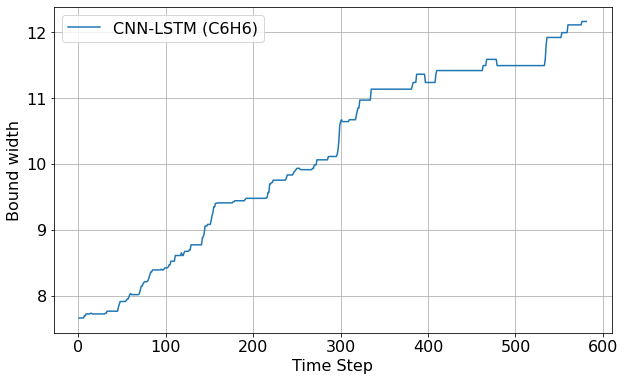

In [130]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["CNN-LSTM (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/cnn_lstm_forecasts_bound_width_C6H6.svg")

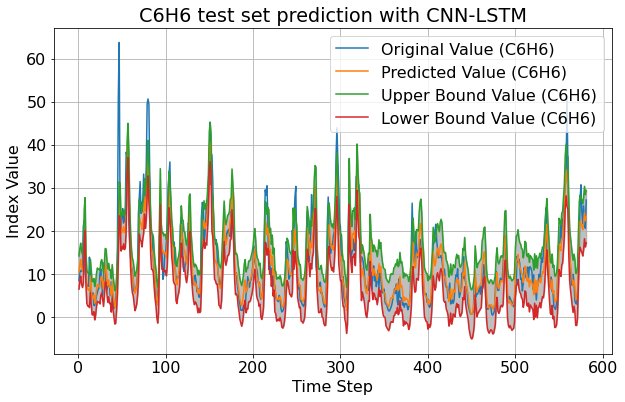

In [131]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("C6H6 test set prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (C6H6)", "Predicted Value (C6H6)", "Upper Bound Value (C6H6)", "Lower Bound Value (C6H6)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/cnn_lstm_forecasts_bounds_C6H6.svg")

In [132]:
rmse_cnn_lstm, mae_cnn_lstm, mape_cnn_lstm= compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"rmse: {rmse_cnn_lstm:.2f}, mae: {mae_cnn_lstm:.2f} , mape: {mape_cnn_lstm:.2f} for forecast")

rmse: 4.53, mae: 2.87 , mape: 29.21 for forecast


In [133]:
# Save model

cnn_lstm_ensemble[0].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_0.h5")
cnn_lstm_ensemble[1].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_1.h5")
cnn_lstm_ensemble[2].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_2.h5")
cnn_lstm_ensemble[3].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_3.h5")
cnn_lstm_ensemble[4].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_4.h5")
cnn_lstm_ensemble[5].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_5.h5")
cnn_lstm_ensemble[6].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_6.h5")
cnn_lstm_ensemble[7].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_7.h5")
cnn_lstm_ensemble[8].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_8.h5")
cnn_lstm_ensemble[9].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_9.h5")
cnn_lstm_ensemble[10].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_10.h5")
cnn_lstm_ensemble[11].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_11.h5")
cnn_lstm_ensemble[12].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_12.h5")
cnn_lstm_ensemble[13].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_13.h5")
cnn_lstm_ensemble[14].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_14.h5")
cnn_lstm_ensemble[15].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_15.h5")
cnn_lstm_ensemble[16].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_16.h5")
cnn_lstm_ensemble[17].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_17.h5")
cnn_lstm_ensemble[18].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_18.h5")
cnn_lstm_ensemble[19].save("/content/gdrive/MyDrive/C6H6/cnn_lstm_ensemble/cnn_lstm_C6H6_19.h5")

# Plot together

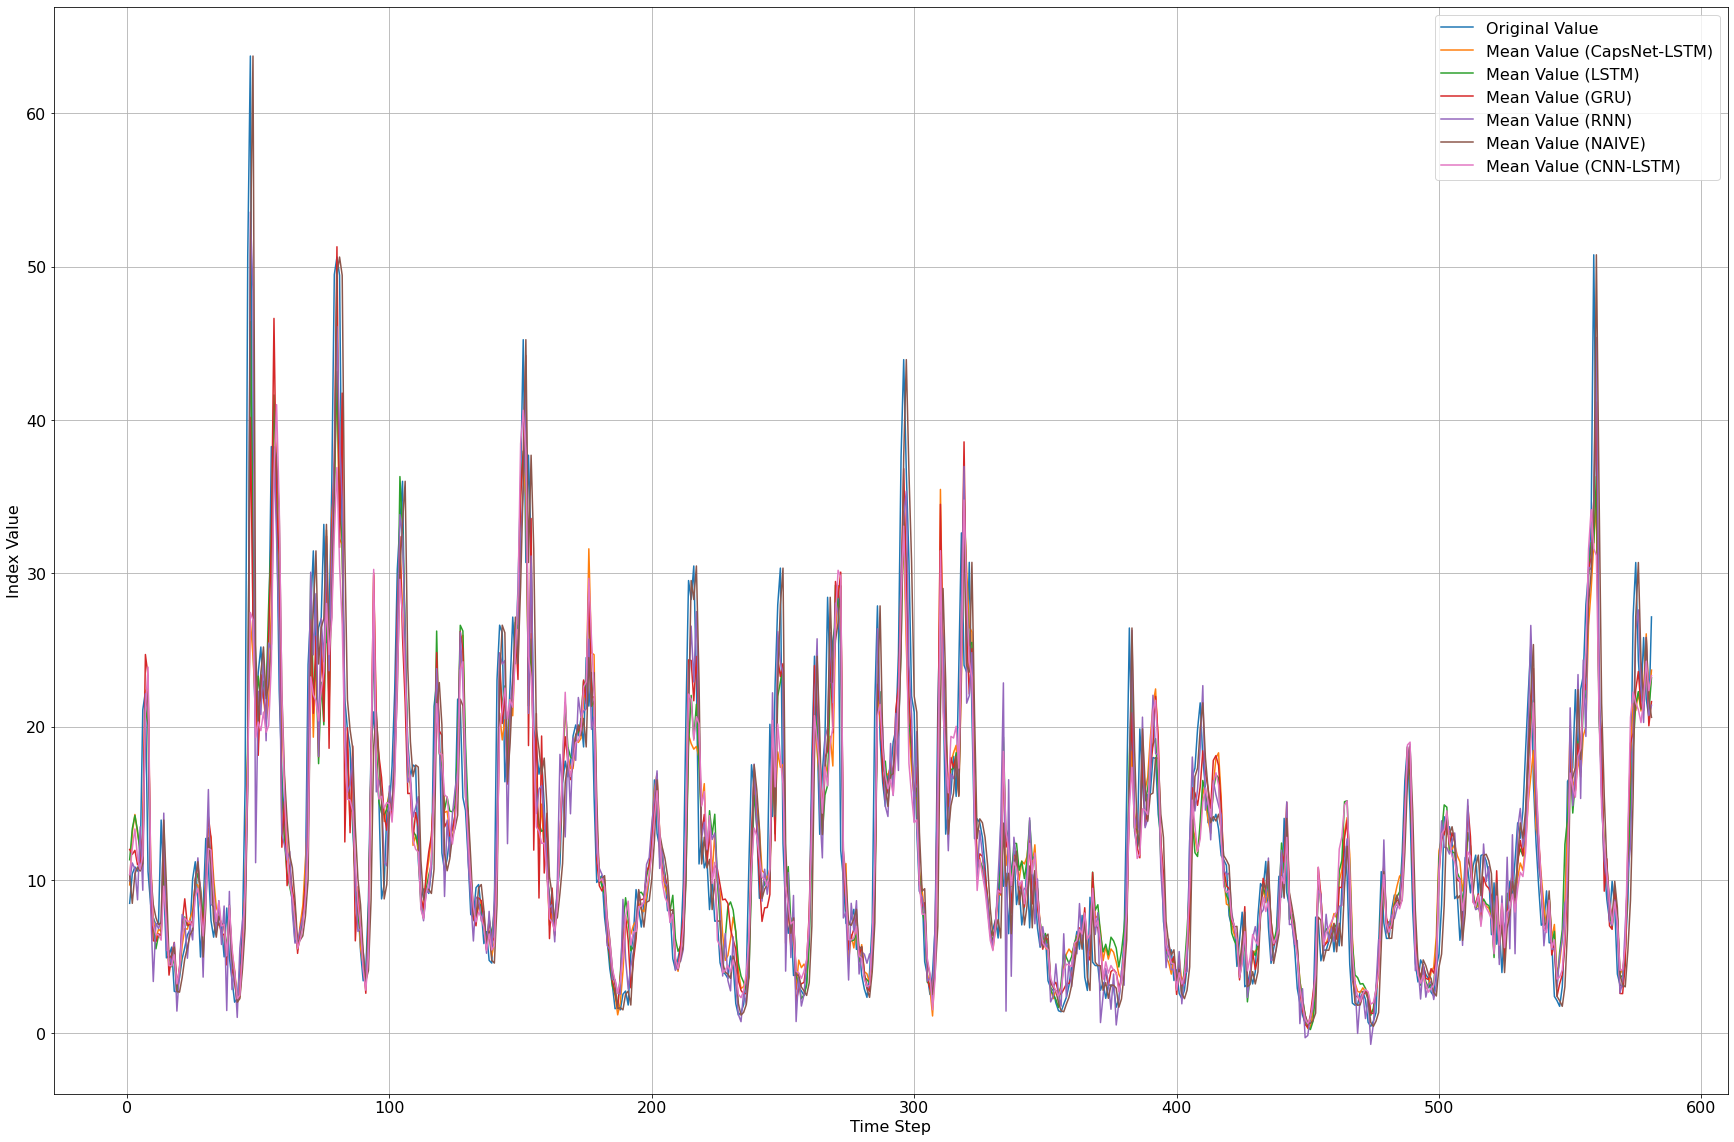

In [134]:
plt.figure(figsize=(30, 20))
plt.rcParams['font.size'] = '16'
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_gru)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)

# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
# plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='green', alpha=0.5)

# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
# plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='yellow', alpha=0.5)

# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
# plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
# plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)


plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value", "Mean Value (CapsNet-LSTM)","Mean Value (LSTM)","Mean Value (GRU)","Mean Value (RNN)","Mean Value (NAIVE)","Mean Value (CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/all_together_forecasts_C6H6.svg")

In [135]:
print(rmse_capsnet_lstm)
print(rmse_lstm)
print(rmse_gru)
print(rmse_rnn)
print(rmse_naive)
print(rmse_cnn_lstm)

4.509851
4.11283
4.283921
4.166366
4.887500999657734
4.5343122


In [136]:
print(mae_capsnet_lstm)
print(mae_lstm)
print(mae_gru)
print(mae_rnn)
print(mae_naive)
print(mae_cnn_lstm)

2.9154792
2.7523184
2.787191
2.7755947
3.105251048574455
2.8721566


In [137]:
print(mape_capsnet_lstm)
print(mape_lstm)
print(mape_gru)
print(mape_rnn)
print(mape_naive)
print(mape_cnn_lstm)

31.074324
31.096184
29.007118
29.815847
28.172948563319228
29.205418


In [138]:
print(PICP_capsnet_lstm)
print(PICP_lstm)
print(PICP_gru)
print(PICP_rnn)
print(PICP_naive)
print(PICP_cnn_lstm)

0.8123924268502581
0.8605851979345955
0.9018932874354562
0.8227194492254734
0.9604130808950087
0.8313253012048193


In [139]:
print(NMPIW_capsnet_lstm)
print(NMPIW_lstm)
print(NMPIW_gru)
print(NMPIW_rnn)
print(NMPIW_naive)
print(NMPIW_cnn_lstm)

tf.Tensor(0.14828059381289466, shape=(), dtype=float64)
tf.Tensor(0.16662628581398872, shape=(), dtype=float64)
tf.Tensor(0.20562403013729805, shape=(), dtype=float64)
tf.Tensor(0.14598769883142804, shape=(), dtype=float64)
tf.Tensor(0.3536539365623268, shape=(), dtype=float64)
tf.Tensor(0.16030788519764985, shape=(), dtype=float64)


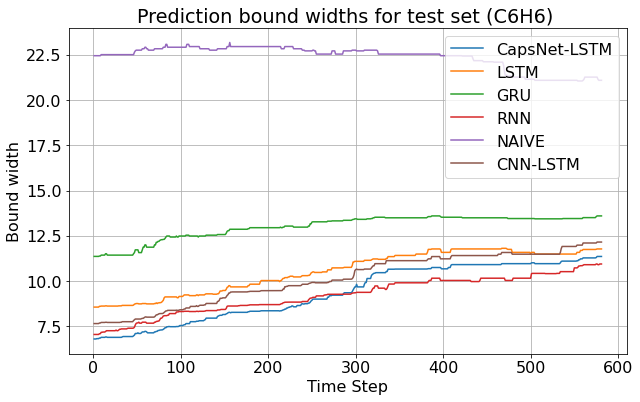

In [140]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_gru)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_rnn)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_naive)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
plt.title("Prediction bound widths for test set (C6H6) ")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","GRU","RNN","NAIVE","CNN-LSTM"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/C6H6/figures/lstm_forecasts_all_bound_widths_C6H6.svg")